# Exploratory Data Analysis (EDA) - Data Science

- Steps:
    - Understand the dataset - assess the quality of the dataset
    - Distribute of the dataset - How does the data look like?
    - Correlactions - Find patterns in the dataset

In [32]:
###############################################################
################### DATA CLEANING #############################
###############################################################

In [33]:
import pandas                   as pd
import sys
import itertools
from collections               import Counter
import numpy                   as np
import gc # Garbage Collector interface
import feather
import time
from datetime                  import datetime
import matplotlib.pyplot       as plt
import seaborn                 as sns
from sklearn.feature_selection import mutual_info_classif
import plotly.express          as ex

##### >>> https://towardsdatascience.com/a-straightforward-guide-to-cleaning-and-preparing-data-in-python-8c82f209ae33
# source dataset: https://www.dataquest.io/blog/machine-learning-preparing-data/

# data cleaning - sources
# https://medium.com/sciforce/data-cleaning-and-preprocessing-for-beginners-25748ee00743
# https://medium.com/bitgrit-data-science-publication/data-cleaning-with-python-f6bc3da64e45
# https://towardsdatascience.com/the-ultimate-guide-to-data-cleaning-3969843991d4
# https://towardsdatascience.com/data-cleaning-and-feature-engineering-the-underestimated-parts-of-machine-learning-10681dae4cf7

# Pandas has a high consume of memory RAM usage
# release memory RAM
def release_memory(df):   
    del df
    gc.collect() 
    df = pd.DataFrame() # point to NULL
    print('memory RAM released.')

# Get start time 
start_time = time.time()

# datetime object containing current date and time
now = datetime.now()

# dd/mm/YY H:M:S
dt_string = now.strftime("%d/%m/%Y %H:%M:%S")
print(">>> date: ", dt_string)

>>> date:  22/07/2021 21:29:40


## Quick Dataset Overview

In [34]:
# dataframe - df
# read csv file, the columns are separated (sep) by ','
df = pd.read_csv('../data/lending_club_loans.csv')
df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,collections_12_mths_ex_med,application_type,chargeoff_within_12_mths,delinq_amnt,pub_rec_bankruptcies,tax_liens
0,1077501,1296599,5000,5000,4975.0,36 months,10.65%,162.87,B,B2,...,0.00,Jan-15,171.62,Jan-17,0.0,INDIVIDUAL,0.0,0,0.0,0.0
1,1077430,1314167,2500,2500,2500.0,60 months,15.27%,59.83,C,C4,...,1.11,Apr-13,119.66,Oct-16,0.0,INDIVIDUAL,0.0,0,0.0,0.0
2,1077175,1313524,2400,2400,2400.0,36 months,15.96%,84.33,C,C5,...,0.00,Jun-14,649.91,Jan-17,0.0,INDIVIDUAL,0.0,0,0.0,0.0
3,1076863,1277178,10000,10000,10000.0,36 months,13.49%,339.31,C,C1,...,0.00,Jan-15,357.48,Apr-16,0.0,INDIVIDUAL,0.0,0,0.0,0.0
4,1075358,1311748,3000,3000,3000.0,60 months,12.69%,67.79,B,B5,...,0.00,Jan-17,67.30,Jan-17,0.0,INDIVIDUAL,0.0,0,0.0,0.0


## Data Dictionary

In [36]:
## df_dict = pd.read_csv("../data/lending_club_loans_dict.csv")

columns = []
descriptions = []

for column in df:
    for index, row in df_dict.iterrows():
        if column == row['LoanStatNew']:
            columns.append(row['LoanStatNew'])
            descriptions.append(row['Description'])

features = {'Features': columns,
            'Descriptions': descriptions }

df_dict_filtered = pd.DataFrame(features)

pd.set_option('display.width', 1000)

df_dict_filtered


,Features,Descriptions
0,id,A unique LC assigned ID for the loan listing.
1,member_id,A unique LC assigned Id for the borrower member.
2,loan_amnt,"The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value."
3,funded_amnt,The total amount committed to that loan at that point in time.
4,funded_amnt_inv,The total amount committed by investors for that loan at that point in time.
5,term,The number of payments on the loan. Values are in months and can be either 36 or 60.
6,int_rate,Interest Rate on the loan
7,installment,The monthly payment owed by the borrower if the loan originates.
8,grade,LC assigned loan grade
9,sub_grade,LC assigned loan subgrade


In [158]:
print(f'Number of rows.....................: {df.shape[0]}')
print(f'Number of columns..................: {df.shape[1]}')

Number of rows.....................: 39786
Number of columns..................: 47


In [73]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39786 entries, 0 to 39785
Data columns (total 47 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          39786 non-null  int64  
 1   member_id                   39786 non-null  int64  
 2   loan_amnt                   39786 non-null  int64  
 3   funded_amnt                 39786 non-null  int64  
 4   funded_amnt_inv             39786 non-null  float64
 5   term                        39786 non-null  object 
 6   int_rate                    39786 non-null  object 
 7   installment                 39786 non-null  float64
 8   grade                       39786 non-null  object 
 9   sub_grade                   39786 non-null  object 
 10  emp_length                  38708 non-null  object 
 11  home_ownership              39786 non-null  object 
 12  annual_inc                  39786 non-null  float64
 13  verification_status         397

In [16]:
df.describe()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,...,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,collections_12_mths_ex_med,chargeoff_within_12_mths,delinq_amnt,pub_rec_bankruptcies,tax_liens
count,3.978600e+04,3.978600e+04,39786.000000,39786.000000,39786.000000,39786.000000,3.978600e+04,39786.000000,39786.000000,39786.000000,...,39786.000000,39786.000000,39786.000000,39786.000000,39786.000000,39730.0,39730.0,39786.0,39089.000000,39747.0
mean,6.833939e+05,8.507937e+05,11231.360277,10958.722289,10409.018679,324.733637,6.897907e+04,13.317794,0.146534,0.869049,...,2276.328632,1.388346,96.701726,12.625390,2679.092793,0.0,0.0,0.0,0.043286,0.0
std,2.106770e+05,2.656370e+05,7464.542832,7194.076908,7135.760122,208.923212,6.376263e+04,6.678300,0.491826,1.070069,...,2632.387428,7.397535,695.728659,149.855504,4443.383020,0.0,0.0,0.0,0.204381,0.0
min,5.473400e+04,7.069900e+04,500.000000,500.000000,0.000000,15.690000,4.000000e+03,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0
25%,5.163518e+05,6.670548e+05,5500.000000,5400.000000,5000.000000,167.080000,4.050000e+04,8.180000,0.000000,0.000000,...,663.045000,0.000000,0.000000,0.000000,218.072500,0.0,0.0,0.0,0.000000,0.0
50%,6.662295e+05,8.515440e+05,10000.000000,9650.000000,8975.000000,280.610000,5.900000e+04,13.410000,0.000000,1.000000,...,1352.805000,0.000000,0.000000,0.000000,549.425000,0.0,0.0,0.0,0.000000,0.0
75%,8.378710e+05,1.047528e+06,15000.000000,15000.000000,14400.000000,430.780000,8.234250e+04,18.600000,0.000000,1.000000,...,2845.567500,0.000000,0.000000,0.000000,3292.122500,0.0,0.0,0.0,0.000000,0.0
max,1.077501e+06,1.314167e+06,35000.000000,35000.000000,35000.000000,1305.190000,6.000000e+06,29.990000,11.000000,8.000000,...,23886.470000,180.200000,29623.350000,7002.190000,36115.200000,0.0,0.0,0.0,2.000000,0.0


In [74]:
# checking how much memory is used by the DataFrame
df.info(verbose=False, memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39786 entries, 0 to 39785
Columns: 47 entries, id to tax_liens
dtypes: float64(18), int64(11), object(18)
memory usage: 51.6 MB


In [77]:
# % of rows missing in each column
list_columns_nan = list()

for column in df.columns:
    percentage = df[column].isnull().mean()
    if(percentage != 0):
        print(f'{round(percentage*100, 2)}% : {column}')
        list_columns_nan.append(column)

2.71% : emp_length
0.13% : revol_util
0.18% : last_pymnt_d
0.01% : last_credit_pull_d
0.14% : collections_12_mths_ex_med
0.14% : chargeoff_within_12_mths
1.75% : pub_rec_bankruptcies
0.1% : tax_liens


## Identify Missing Data

In [59]:
# count NaN found in the dataset
df.isna().sum().sort_values(ascending = False).head(10)

emp_length                    1078
pub_rec_bankruptcies           697
last_pymnt_d                    71
chargeoff_within_12_mths        56
collections_12_mths_ex_med      56
revol_util                      50
tax_liens                       39
last_credit_pull_d               2
total_rec_prncp                  0
total_acc                        0
dtype: int64

## Missing value per feature - heatmap

<AxesSubplot:title={'center':'Missing Values Per Feature'}>

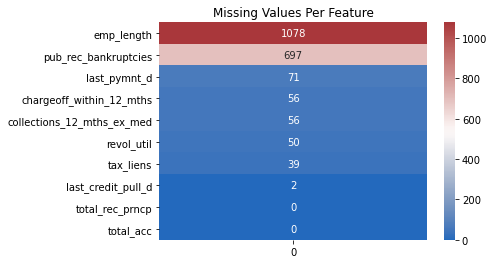

In [61]:
# heatmap - give a big picture of the missing values on the dataset.
plt.title('Missing Values Per Feature')
nans = df.isna().sum().sort_values(ascending=False).head(10).to_frame() # get NaN
sns.heatmap(nans,annot=True,fmt='d',cmap='vlag') # seaborn

In [21]:
#df = df.dropna() # drop rows with NaN's
df.shape

(39786, 47)

In [22]:
# remove rows with missing data
#df = df.dropna()

# drop a column
# df.drop('column_name', axis=1)

# Replace it by the mean, median or mode

In [23]:
df[list_columns_nan].head()

,emp_length,revol_util,last_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,chargeoff_within_12_mths,pub_rec_bankruptcies,tax_liens
0,10+ years,83.70%,Jan-15,Jan-17,0.0,0.0,0.0,0.0
1,< 1 year,9.40%,Apr-13,Oct-16,0.0,0.0,0.0,0.0
2,10+ years,98.50%,Jun-14,Jan-17,0.0,0.0,0.0,0.0
3,10+ years,21%,Jan-15,Apr-16,0.0,0.0,0.0,0.0
4,1 year,53.90%,Jan-17,Jan-17,0.0,0.0,0.0,0.0


In [24]:
# remove a special character on dataframe
df['revol_util'] = df['revol_util'].str.replace('%', '')
df['int_rate'] = df['int_rate'].str.replace('%', '')

# Convert object to float
df[['revol_util','int_rate']] = df[['revol_util','int_rate']].astype(float)

# convert obejcto category
list_cat = ['last_pymnt_d', 'last_credit_pull_d']

for ilist in list_cat:
    df[f'{ilist}'] = df[f'{ilist}'].astype('category')

In [25]:
df[list_columns_nan].dtypes

emp_length                      object
revol_util                     float64
last_pymnt_d                  category
last_credit_pull_d            category
collections_12_mths_ex_med     float64
chargeoff_within_12_mths       float64
pub_rec_bankruptcies           float64
tax_liens                      float64
dtype: object

In [26]:
# the mode replaces categorical data.
mode = ''.join(df['emp_length'].mode())
df['emp_length'].fillna(mode, inplace=True)

# datetime
list_datetime = ['last_pymnt_d', 'last_credit_pull_d']

for ilist in list_datetime:
    mode = ''.join(df[f'{ilist}'].mode())
    df[f'{ilist}'].fillna(mode, inplace=True)


# list columns float
list_impute_mean = ['revol_util',
                    'collections_12_mths_ex_med',
                    'chargeoff_within_12_mths',
                    'pub_rec_bankruptcies',
                    'tax_liens'
                   ]

# impute mean to missing values
df = df.fillna(df[list_impute_mean].mean())

In [27]:
df[list_columns_nan].dtypes

emp_length                      object
revol_util                     float64
last_pymnt_d                  category
last_credit_pull_d            category
collections_12_mths_ex_med     float64
chargeoff_within_12_mths       float64
pub_rec_bankruptcies           float64
tax_liens                      float64
dtype: object

In [28]:
df

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,collections_12_mths_ex_med,application_type,chargeoff_within_12_mths,delinq_amnt,pub_rec_bankruptcies,tax_liens
0,1077501,1296599,5000,5000,4975.0,36 months,10.65,162.87,B,B2,...,0.00,Jan-15,171.62,Jan-17,0.0,INDIVIDUAL,0.0,0,0.000000,0.0
1,1077430,1314167,2500,2500,2500.0,60 months,15.27,59.83,C,C4,...,1.11,Apr-13,119.66,Oct-16,0.0,INDIVIDUAL,0.0,0,0.000000,0.0
2,1077175,1313524,2400,2400,2400.0,36 months,15.96,84.33,C,C5,...,0.00,Jun-14,649.91,Jan-17,0.0,INDIVIDUAL,0.0,0,0.000000,0.0
3,1076863,1277178,10000,10000,10000.0,36 months,13.49,339.31,C,C1,...,0.00,Jan-15,357.48,Apr-16,0.0,INDIVIDUAL,0.0,0,0.000000,0.0
4,1075358,1311748,3000,3000,3000.0,60 months,12.69,67.79,B,B5,...,0.00,Jan-17,67.30,Jan-17,0.0,INDIVIDUAL,0.0,0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39781,92187,92174,2500,2500,1075.0,36 months,8.07,78.42,A,A4,...,0.00,Jul-10,80.90,Jun-10,0.0,INDIVIDUAL,0.0,0,0.043286,0.0
39782,90665,90607,8500,8500,875.0,36 months,10.28,275.38,C,C1,...,0.00,Jul-10,281.94,Jul-10,0.0,INDIVIDUAL,0.0,0,0.043286,0.0
39783,90395,90390,5000,5000,1325.0,36 months,8.07,156.84,A,A4,...,0.00,Apr-08,0.00,Jun-07,0.0,INDIVIDUAL,0.0,0,0.043286,0.0
39784,90376,89243,5000,5000,650.0,36 months,7.43,155.38,A,A2,...,0.00,Jan-08,0.00,Jun-07,0.0,INDIVIDUAL,0.0,0,0.043286,0.0


## Dealing with Missing Data

In [29]:
print(f'Number of rows.....................: {df.shape[0]}')
print(f'Number of columns..................: {df.shape[1]}')

Number of rows.....................: 39786
Number of columns..................: 47


In [30]:
# count NaN found in the dataset
df.isna().sum()

id                            0
member_id                     0
loan_amnt                     0
funded_amnt                   0
funded_amnt_inv               0
term                          0
int_rate                      0
installment                   0
grade                         0
sub_grade                     0
emp_length                    0
home_ownership                0
annual_inc                    0
verification_status           0
issue_d                       0
loan_status                   0
pymnt_plan                    0
zip_code                      0
addr_state                    0
dti                           0
delinq_2yrs                   0
earliest_cr_line              0
inq_last_6mths                0
open_acc                      0
pub_rec                       0
revol_bal                     0
revol_util                    0
total_acc                     0
initial_list_status           0
out_prncp                     0
out_prncp_inv                 0
total_py

# Visualization - Columns

array([[<AxesSubplot:title={'center':'id'}>,
        <AxesSubplot:title={'center':'member_id'}>,
        <AxesSubplot:title={'center':'loan_amnt'}>,
        <AxesSubplot:title={'center':'funded_amnt'}>,
        <AxesSubplot:title={'center':'funded_amnt_inv'}>,
        <AxesSubplot:title={'center':'int_rate'}>],
       [<AxesSubplot:title={'center':'installment'}>,
        <AxesSubplot:title={'center':'annual_inc'}>,
        <AxesSubplot:title={'center':'dti'}>,
        <AxesSubplot:title={'center':'delinq_2yrs'}>,
        <AxesSubplot:title={'center':'inq_last_6mths'}>,
        <AxesSubplot:title={'center':'open_acc'}>],
       [<AxesSubplot:title={'center':'pub_rec'}>,
        <AxesSubplot:title={'center':'revol_bal'}>,
        <AxesSubplot:title={'center':'revol_util'}>,
        <AxesSubplot:title={'center':'total_acc'}>,
        <AxesSubplot:title={'center':'out_prncp'}>,
        <AxesSubplot:title={'center':'out_prncp_inv'}>],
       [<AxesSubplot:title={'center':'total_pymnt'}>,
 

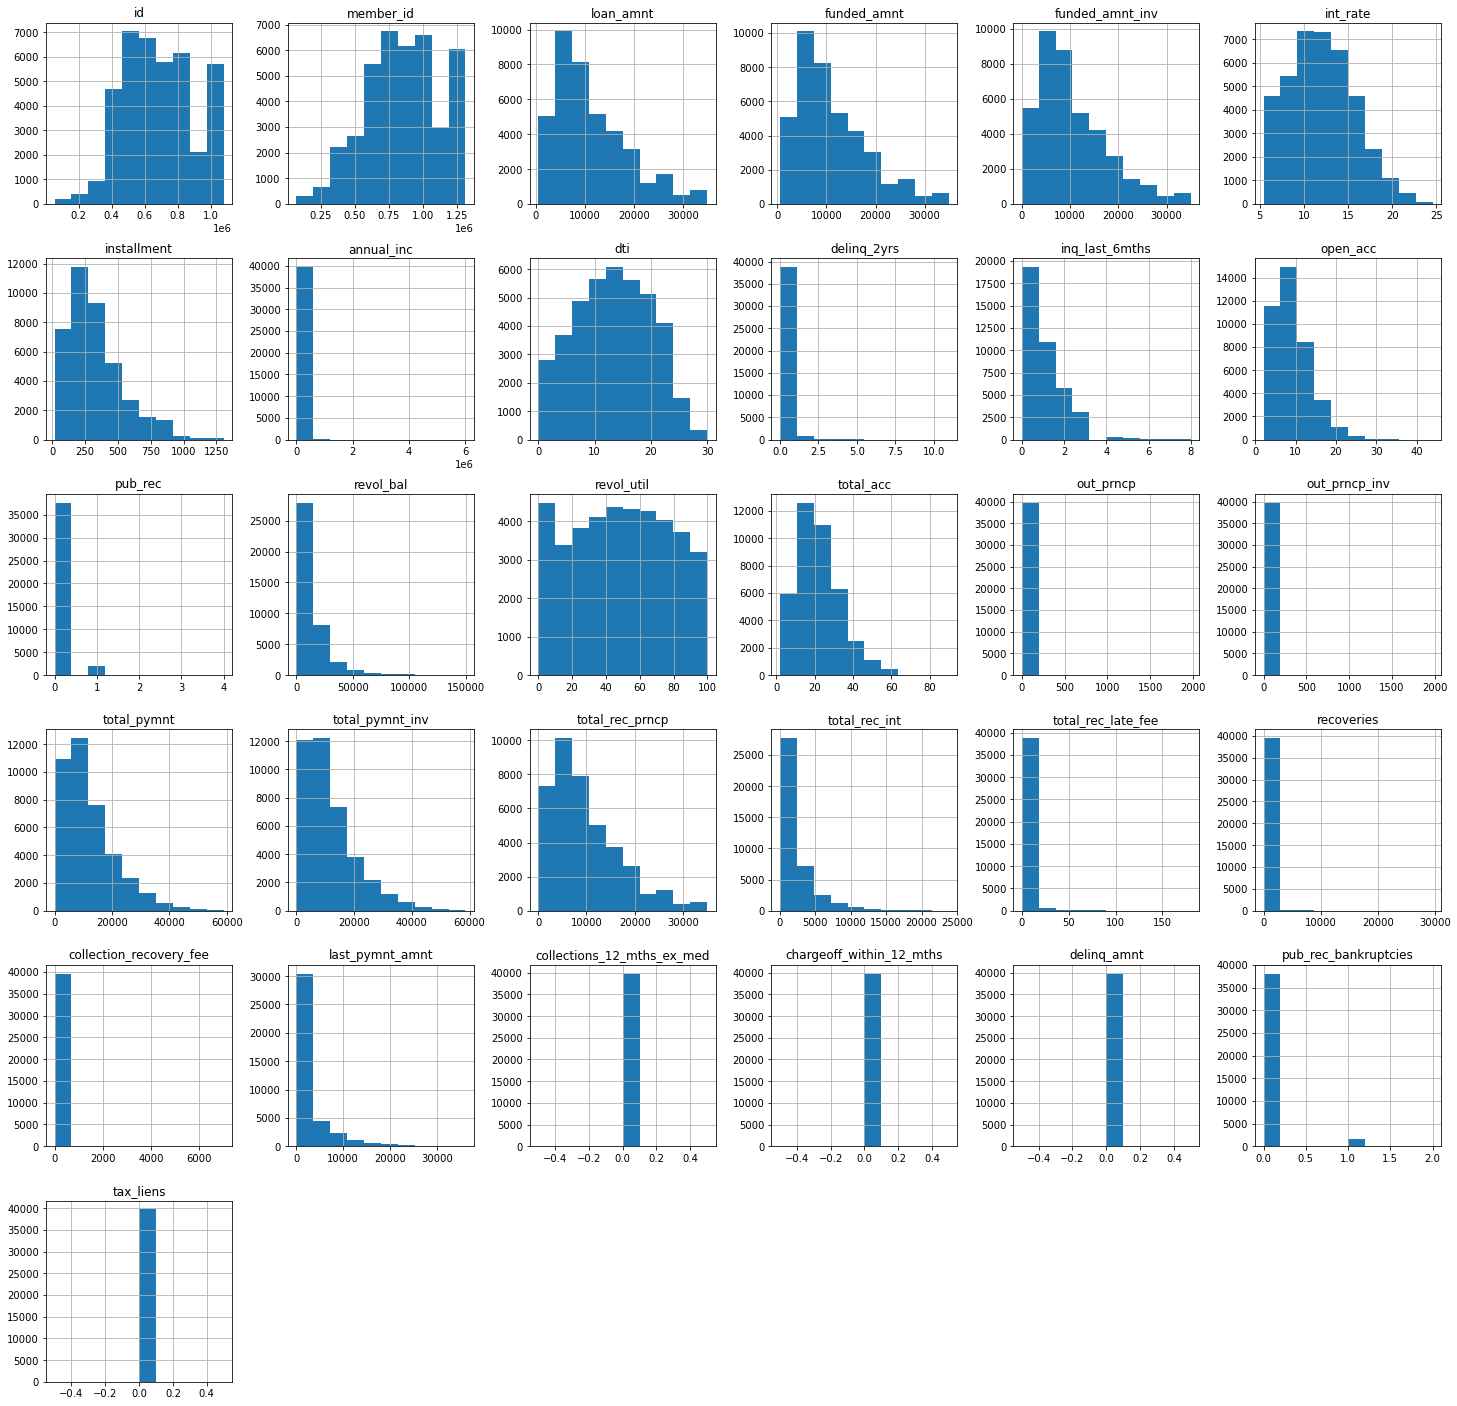

In [31]:
df.hist(figsize=(25, 25))

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39786 entries, 0 to 39785
Data columns (total 47 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   id                          39786 non-null  int64   
 1   member_id                   39786 non-null  int64   
 2   loan_amnt                   39786 non-null  int64   
 3   funded_amnt                 39786 non-null  int64   
 4   funded_amnt_inv             39786 non-null  float64 
 5   term                        39786 non-null  object  
 6   int_rate                    39786 non-null  float64 
 7   installment                 39786 non-null  float64 
 8   grade                       39786 non-null  object  
 9   sub_grade                   39786 non-null  object  
 10  emp_length                  39786 non-null  object  
 11  home_ownership              39786 non-null  object  
 12  annual_inc                  39786 non-null  float64 
 13  verification_sta

In [33]:
#df_ocean_proximity_cat = df['ocean_proximity'].value_counts(normalize=True).map('{:.2%}'.format)
#ex.pie(df_ocean_proximity_cat,names='ocean_proximity',title='ocean_proximity')

In [34]:
print("saving the file format feather...")

# this is important to do before save in feather format.
df = df.reset_index(drop=True) # reset index pandas before save feather format
df.to_feather('../data/dataset_cleaning.ftr') # save to feather format

release_memory(df)

saving the file format feather...
memory RAM released.


In [35]:
# time of execution in minutes
time_exec_min = round( (time.time() - start_time)/60, 4)

print(f'time of execution (preprocessing): {time_exec_min} minutes')
print("the preprocessing is done.")
print("The next step is to do the feature engineering.")
# datetime object containing current date and time
now = datetime.now()

# dd/mm/YY H:M:S
dt_string = now.strftime("%d/%m/%Y %H:%M:%S")
print(">>> date: ", dt_string)

print("All Done. :)")

time of execution (preprocessing): 1.9152 minutes
the preprocessing is done.
The next step is to do the feature engineering.
>>> date:  21/07/2021 08:20:45
All Done. :)
